https://arxiv.org/pdf/1806.07366.pdf

In [46]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torchdiffeq import odeint_adjoint
from torchdiffeq import odeint

# Spiral

In [47]:
def spiral(t):
    yx = torch.cos(t) * 2. * t
    yy = torch.sin(t) * 2. * t
    return torch.vstack((yx, yy))

In [48]:
x_train = torch.linspace(15,5,100)
y_train = spiral(x_train)
x_test = torch.linspace(5,1,30).reshape(-1)
y_test = spiral(x_test).T

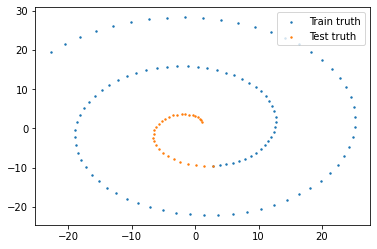

In [49]:
#collapse_hide
plt.scatter(y_train[0], y_train[1], s=2, label='Train truth')
plt.scatter(y_test[:,0], y_test[:,1], s=2, label='Test truth')
plt.legend()
plt.show()

# Markdown

In [50]:
baseline = nn.Sequential(
    nn.Linear(1, 100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,2)
)

In [51]:
class Sine(nn.Module):
    """Sine activation with scaling.
    Args:
        w0 (float): Omega_0 parameter from SIREN paper.
    """
    def __init__(self, w0=1.):
        super().__init__()
        self.w0 = w0

    def forward(self, x):
        return torch.sin(self.w0 * x)

In [52]:
baseline = nn.Sequential(
    nn.Linear(1, 100),
    Sine(),
    nn.Linear(100,100),
    Sine(),
    nn.Linear(100,2)
)

In [53]:
def optimize_rough(net, x, y, steps):
    optimizer = torch.optim.Adam(net.parameters())
    criterion = nn.MSELoss()
    losses = []
    for i in range(steps):
        optimizer.zero_grad()
        y_pred = net(x)
        loss = criterion(y_pred, y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    plt.scatter(torch.arange(len(losses)),losses)
    plt.title('Training loss')
    plt.show()
    return net(x).detach()

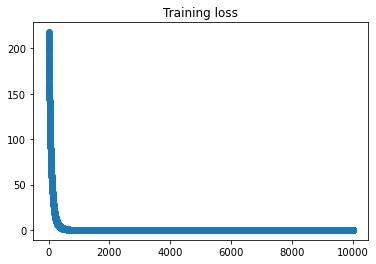

In [54]:
y_pred = optimize_rough(baseline, x_train.reshape(-1,1), y_train.T, 10000)

In [55]:
y_pred_test = baseline(x_test.reshape(-1,1)).detach()

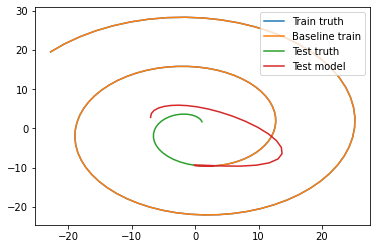

In [56]:
#hide_collapse
plt.plot(y_train[0], y_train[1], label='Train truth')
plt.plot(y_pred[:,0].detach(), y_pred[:,1], label='Baseline train')
plt.plot(y_test[:,0], y_test[:,1], label='Test truth')
plt.plot(y_pred_test[:,0], y_pred_test[:,1], label='Test model')
plt.legend()
plt.show()

# Neural Spiral model

In [57]:
class NeuralODE(nn.Module):
    def __init__(self, phase_space_dim, projection_dim, hidden_layer_dim):
        super().__init__()
        self.delta_net = nn.Sequential(
            nn.Linear(projection_dim + 1, hidden_layer_dim),
            Sine(),
            nn.Linear(hidden_layer_dim, hidden_layer_dim),
            Sine(),
            nn.Linear(hidden_layer_dim, hidden_layer_dim),
            Sine(),
            nn.Linear(hidden_layer_dim, projection_dim),
        )
        self.upprojector_net = nn.Linear(phase_space_dim + 1, projection_dim)
        self.downprojector_net = nn.Linear(projection_dim, phase_space_dim)

    def up(self, t, y):
        concat = torch.hstack((t.reshape(1,1), y.reshape(1,-1)))
        z = self.upprojector_net(concat)
        return z.reshape(-1)

    def down(self, z):
        return self.downprojector_net(z.T).T

    def forward(self, t, yt):
        concat = torch.hstack((t.reshape(1,1), yt.reshape(1,-1)))
        return self.delta_net(concat).reshape(-1)

    def solve(self, y_start, t_start, t_stop, t_steps):
        z_start = self.up(torch.tensor(t_start), y_start)
        timepoints = torch.linspace(t_start,t_stop,t_steps)
        z_pred = odeint(self, z_start, timepoints).T
        return z_pred

In [58]:
nOde = NeuralODE(2,50,100)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(nOde.parameters())

In [59]:
t_limit = 3

Iteration 0
selected torch.Size([2, 3])
Loss: tensor(388.6437, grad_fn=<MseLossBackward>)


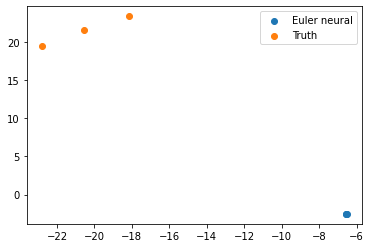

Current t limit 3
Iteration 1
selected torch.Size([2, 3])
Loss: tensor(361.7347, grad_fn=<MseLossBackward>)


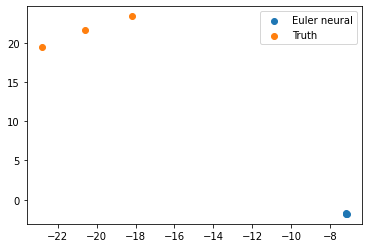

Current t limit 3
Iteration 2
selected torch.Size([2, 3])
Loss: tensor(336.0899, grad_fn=<MseLossBackward>)


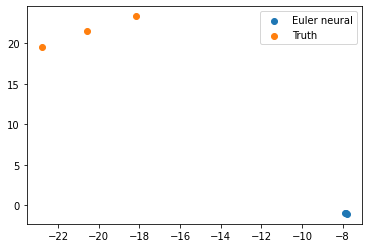

Current t limit 3
Iteration 3
selected torch.Size([2, 3])
Loss: tensor(311.5627, grad_fn=<MseLossBackward>)


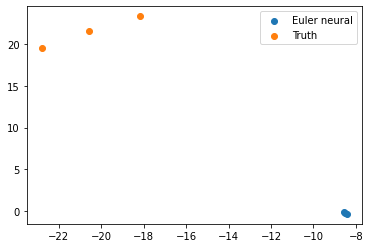

Current t limit 3
Iteration 4
selected torch.Size([2, 3])
Loss: tensor(288.0404, grad_fn=<MseLossBackward>)


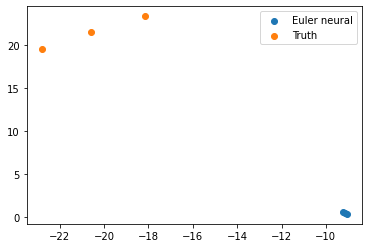

Current t limit 3
Iteration 5
selected torch.Size([2, 3])
Loss: tensor(265.4780, grad_fn=<MseLossBackward>)


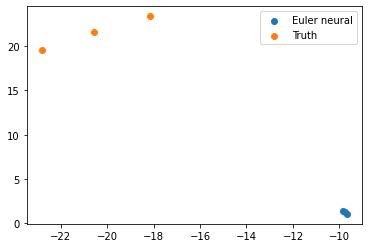

Current t limit 3
Iteration 6
selected torch.Size([2, 3])
Loss: tensor(243.8329, grad_fn=<MseLossBackward>)


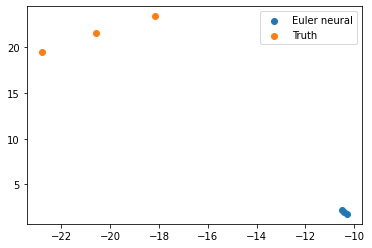

Current t limit 3
Iteration 7
selected torch.Size([2, 3])
Loss: tensor(223.1361, grad_fn=<MseLossBackward>)


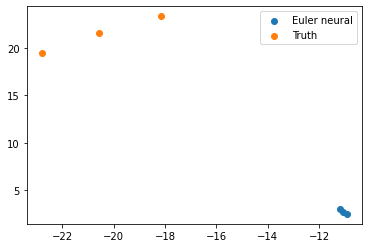

Current t limit 3
Iteration 8
selected torch.Size([2, 3])
Loss: tensor(203.4708, grad_fn=<MseLossBackward>)


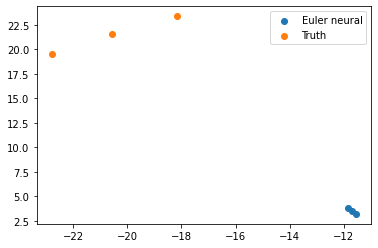

Current t limit 3
Iteration 9
selected torch.Size([2, 3])
Loss: tensor(184.8858, grad_fn=<MseLossBackward>)


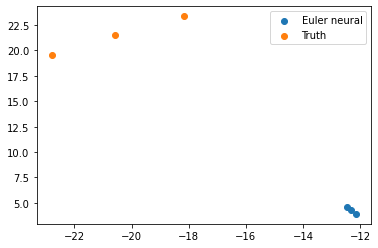

Current t limit 3
Iteration 10
selected torch.Size([2, 3])
Loss: tensor(167.3940, grad_fn=<MseLossBackward>)


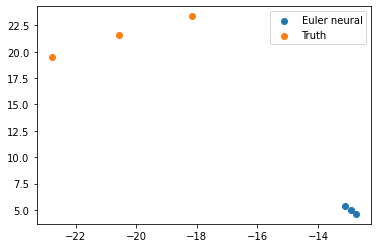

Current t limit 3
Iteration 11
selected torch.Size([2, 3])
Loss: tensor(150.9951, grad_fn=<MseLossBackward>)


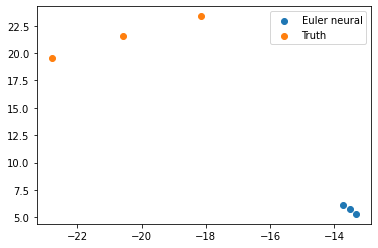

Current t limit 3
Iteration 12
selected torch.Size([2, 3])
Loss: tensor(135.6800, grad_fn=<MseLossBackward>)


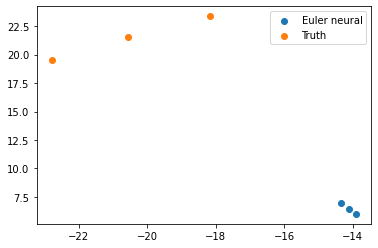

Current t limit 3
Iteration 13
selected torch.Size([2, 3])
Loss: tensor(121.4274, grad_fn=<MseLossBackward>)


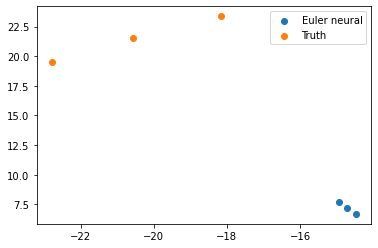

Current t limit 3
Iteration 14
selected torch.Size([2, 3])
Loss: tensor(108.2077, grad_fn=<MseLossBackward>)


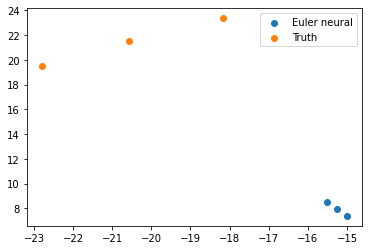

Current t limit 3
Iteration 15
selected torch.Size([2, 3])
Loss: tensor(95.9905, grad_fn=<MseLossBackward>)


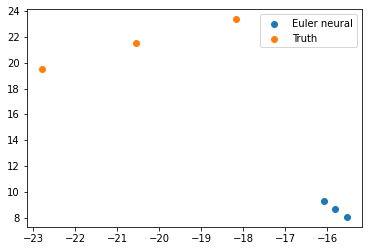

Current t limit 3
Iteration 16
selected torch.Size([2, 3])
Loss: tensor(84.7472, grad_fn=<MseLossBackward>)


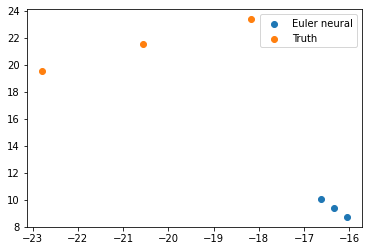

Current t limit 3
Iteration 17
selected torch.Size([2, 3])
Loss: tensor(74.4522, grad_fn=<MseLossBackward>)


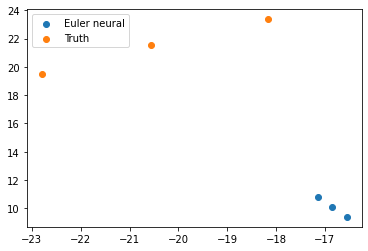

Current t limit 3
Iteration 18
selected torch.Size([2, 3])
Loss: tensor(65.0816, grad_fn=<MseLossBackward>)


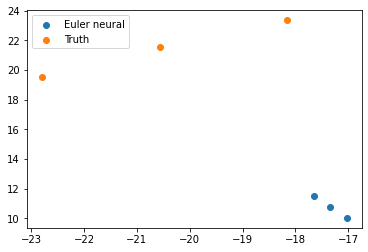

Current t limit 3
Iteration 19
selected torch.Size([2, 3])
Loss: tensor(56.6028, grad_fn=<MseLossBackward>)


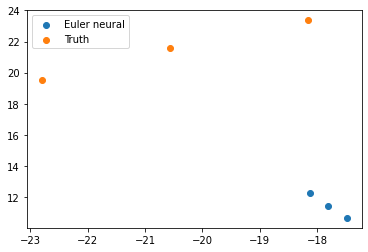

Current t limit 3
Iteration 20
selected torch.Size([2, 3])
Loss: tensor(48.9640, grad_fn=<MseLossBackward>)


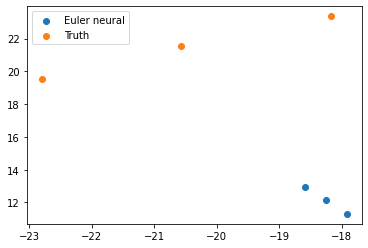

Current t limit 3
Iteration 21
selected torch.Size([2, 3])
Loss: tensor(42.1233, grad_fn=<MseLossBackward>)


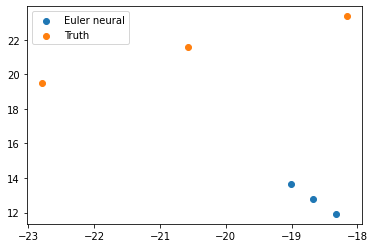

Current t limit 3
Iteration 22
selected torch.Size([2, 3])
Loss: tensor(36.0476, grad_fn=<MseLossBackward>)


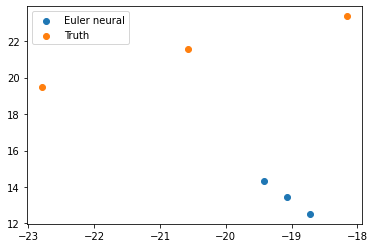

Current t limit 3
Iteration 23
selected torch.Size([2, 3])
Loss: tensor(30.6812, grad_fn=<MseLossBackward>)


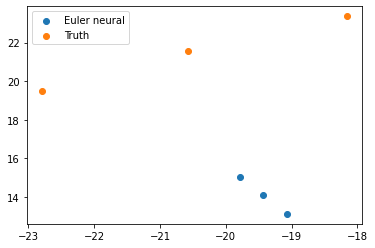

Current t limit 3
Iteration 24
selected torch.Size([2, 3])
Loss: tensor(25.9709, grad_fn=<MseLossBackward>)


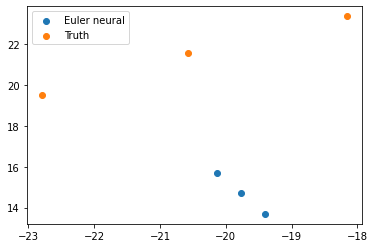

Current t limit 3
Iteration 25
selected torch.Size([2, 3])
Loss: tensor(21.8768, grad_fn=<MseLossBackward>)


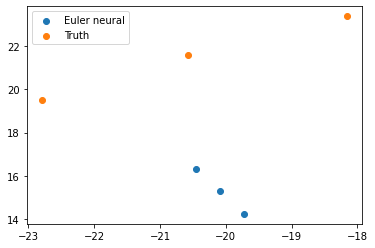

Current t limit 3
Iteration 26
selected torch.Size([2, 3])
Loss: tensor(18.3370, grad_fn=<MseLossBackward>)


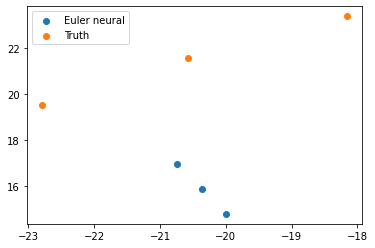

Current t limit 3
Iteration 27
selected torch.Size([2, 3])
Loss: tensor(15.3050, grad_fn=<MseLossBackward>)


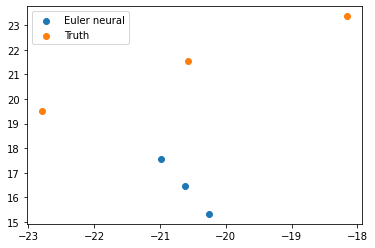

Current t limit 3
Iteration 28
selected torch.Size([2, 3])
Loss: tensor(12.7373, grad_fn=<MseLossBackward>)


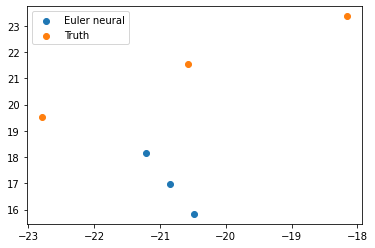

Current t limit 3
Iteration 29
selected torch.Size([2, 3])
Loss: tensor(10.5783, grad_fn=<MseLossBackward>)


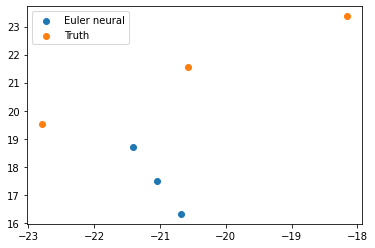

Current t limit 3
Iteration 30
selected torch.Size([2, 3])
Loss: tensor(8.7859, grad_fn=<MseLossBackward>)


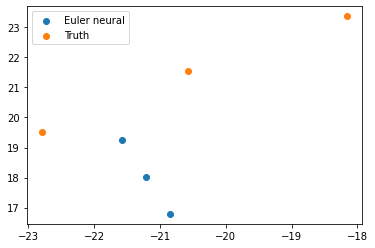

Current t limit 3
Iteration 31
selected torch.Size([2, 3])
Loss: tensor(7.3179, grad_fn=<MseLossBackward>)


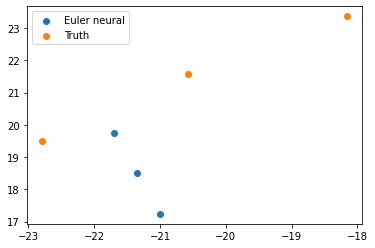

Current t limit 3
Iteration 32
selected torch.Size([2, 3])
Loss: tensor(6.1284, grad_fn=<MseLossBackward>)


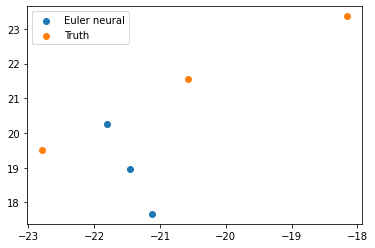

Current t limit 3
Iteration 33
selected torch.Size([2, 3])
Loss: tensor(5.1815, grad_fn=<MseLossBackward>)


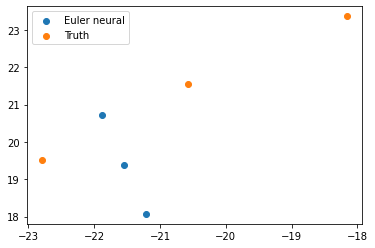

Current t limit 3
Iteration 34
selected torch.Size([2, 3])
Loss: tensor(4.4438, grad_fn=<MseLossBackward>)


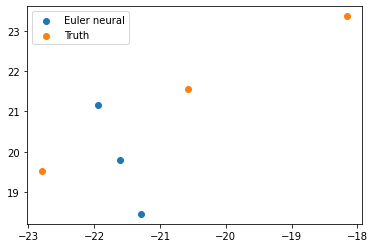

Current t limit 3
Iteration 35
selected torch.Size([2, 3])
Loss: tensor(3.8817, grad_fn=<MseLossBackward>)


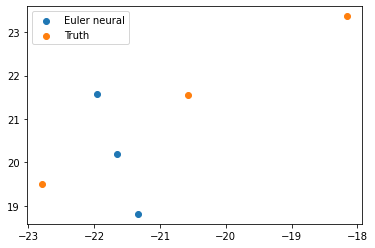

Current t limit 3
Iteration 36
selected torch.Size([2, 3])
Loss: tensor(3.4661, grad_fn=<MseLossBackward>)


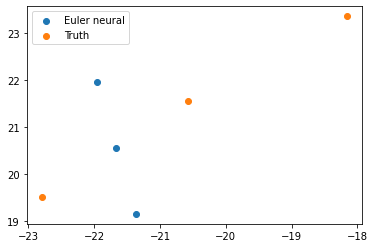

Current t limit 3
Iteration 37
selected torch.Size([2, 3])
Loss: tensor(3.1714, grad_fn=<MseLossBackward>)


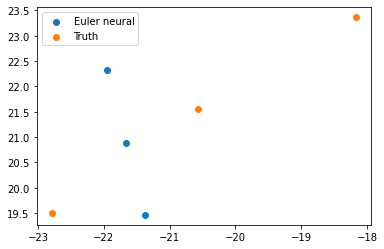

Current t limit 3
Iteration 38
selected torch.Size([2, 3])
Loss: tensor(2.9748, grad_fn=<MseLossBackward>)


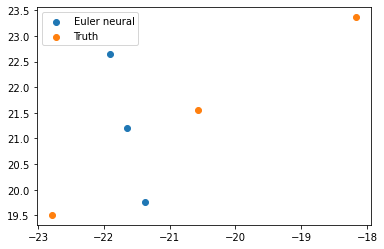

Current t limit 3
Iteration 39
selected torch.Size([2, 3])
Loss: tensor(2.8560, grad_fn=<MseLossBackward>)


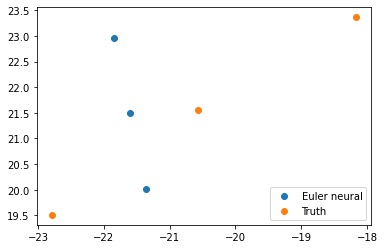

Current t limit 3
Iteration 40
selected torch.Size([2, 3])
Loss: tensor(2.7968, grad_fn=<MseLossBackward>)


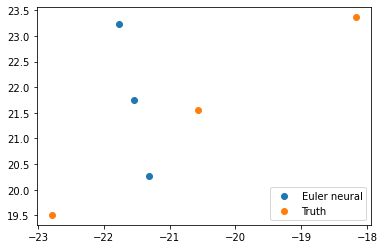

Current t limit 3
Iteration 41
selected torch.Size([2, 3])
Loss: tensor(2.7796, grad_fn=<MseLossBackward>)


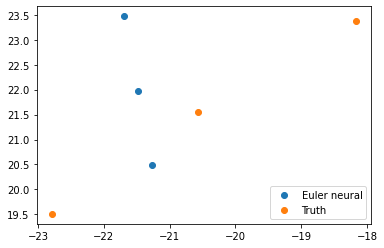

Current t limit 3
Iteration 42
selected torch.Size([2, 3])
Loss: tensor(2.7815, grad_fn=<MseLossBackward>)


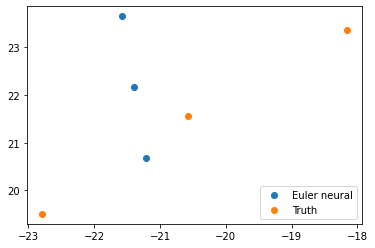

Current t limit 3
Iteration 43
selected torch.Size([2, 3])
Loss: tensor(2.7472, grad_fn=<MseLossBackward>)


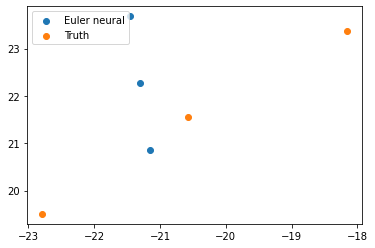

Current t limit 3
Iteration 44
selected torch.Size([2, 3])
Loss: tensor(2.5925, grad_fn=<MseLossBackward>)


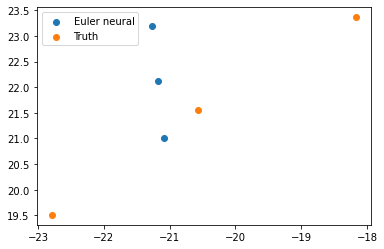

Current t limit 3
Iteration 45
selected torch.Size([2, 3])
Loss: tensor(2.7509, grad_fn=<MseLossBackward>)


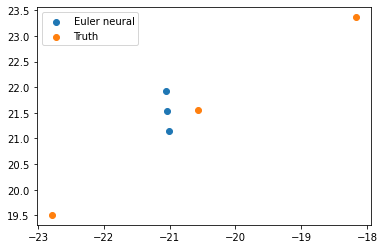

Current t limit 3
Iteration 46
selected torch.Size([2, 3])
Loss: tensor(2.5662, grad_fn=<MseLossBackward>)


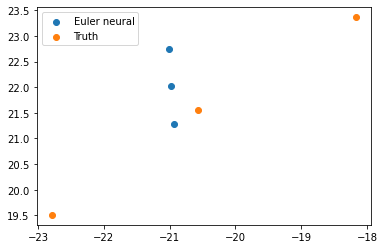

Current t limit 3
Iteration 47
selected torch.Size([2, 3])
Loss: tensor(2.6582, grad_fn=<MseLossBackward>)


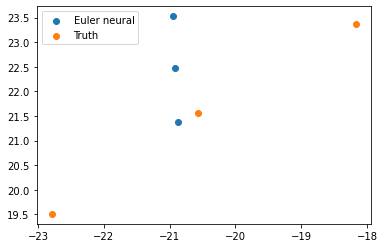

Current t limit 3
Iteration 48
selected torch.Size([2, 3])
Loss: tensor(2.7020, grad_fn=<MseLossBackward>)


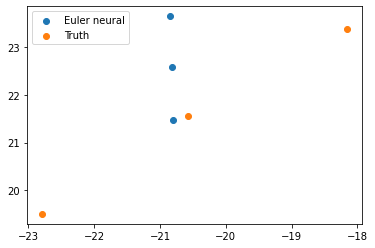

Current t limit 3
Iteration 49
selected torch.Size([2, 3])
Loss: tensor(2.6237, grad_fn=<MseLossBackward>)


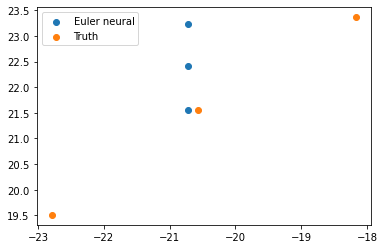

Current t limit 3
Iteration 50
selected torch.Size([2, 3])
Loss: tensor(2.6590, grad_fn=<MseLossBackward>)


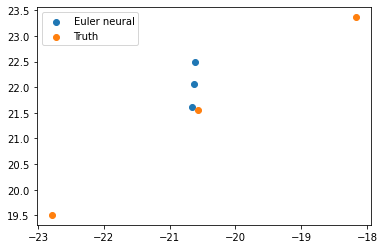

Current t limit 3
Iteration 51
selected torch.Size([2, 3])
Loss: tensor(2.7093, grad_fn=<MseLossBackward>)


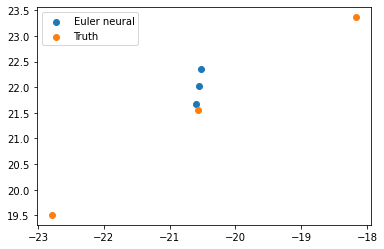

Current t limit 3
Iteration 52
selected torch.Size([2, 3])
Loss: tensor(2.6534, grad_fn=<MseLossBackward>)


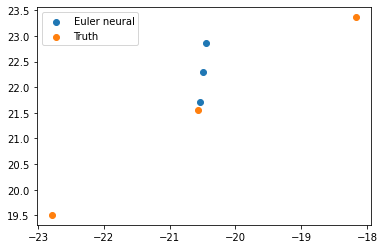

Current t limit 3
Iteration 53
selected torch.Size([2, 3])
Loss: tensor(2.6983, grad_fn=<MseLossBackward>)


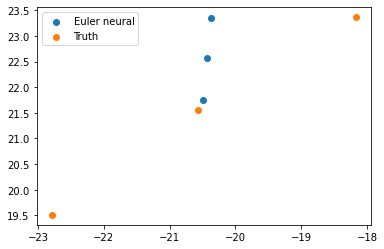

Current t limit 3
Iteration 54
selected torch.Size([2, 3])
Loss: tensor(2.7245, grad_fn=<MseLossBackward>)


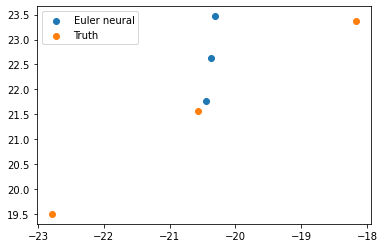

Current t limit 3
Iteration 55
selected torch.Size([2, 3])
Loss: tensor(2.6845, grad_fn=<MseLossBackward>)


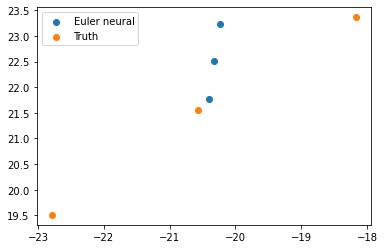

Current t limit 3
Iteration 56
selected torch.Size([2, 3])
Loss: tensor(2.6686, grad_fn=<MseLossBackward>)


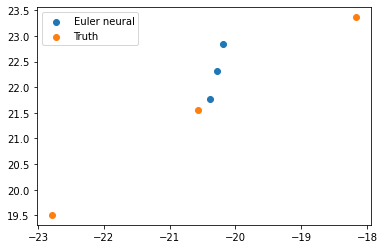

Current t limit 3
Iteration 57
selected torch.Size([2, 3])
Loss: tensor(2.6842, grad_fn=<MseLossBackward>)


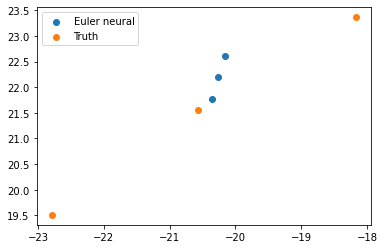

Current t limit 3
Iteration 58
selected torch.Size([2, 3])
Loss: tensor(2.6549, grad_fn=<MseLossBackward>)


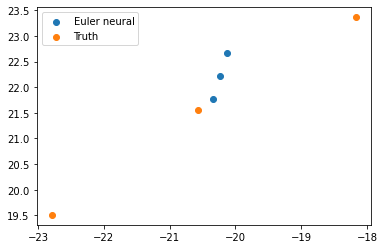

Current t limit 3
Iteration 59
selected torch.Size([2, 3])
Loss: tensor(2.6064, grad_fn=<MseLossBackward>)


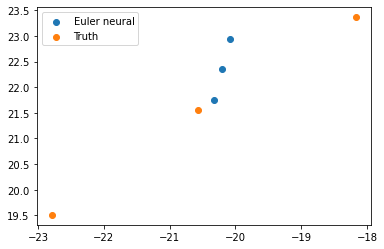

Current t limit 3
Iteration 60
selected torch.Size([2, 3])
Loss: tensor(2.5801, grad_fn=<MseLossBackward>)


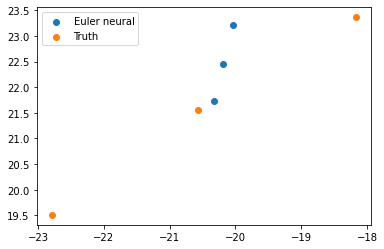

Current t limit 3
Iteration 61
selected torch.Size([2, 3])
Loss: tensor(2.5509, grad_fn=<MseLossBackward>)


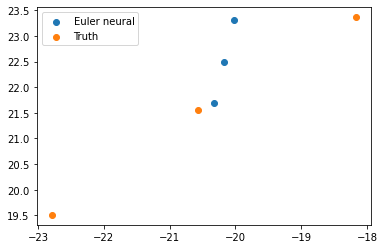

Current t limit 3
Iteration 62
selected torch.Size([2, 3])
Loss: tensor(2.4970, grad_fn=<MseLossBackward>)


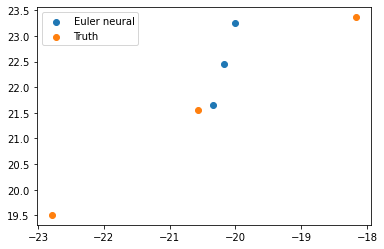

Current t limit 3
Iteration 63
selected torch.Size([2, 3])
Loss: tensor(2.4351, grad_fn=<MseLossBackward>)


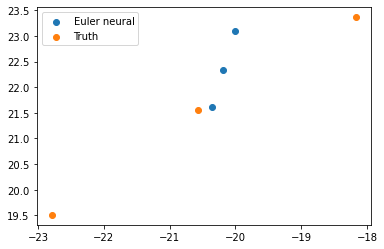

Current t limit 3
Iteration 64
selected torch.Size([2, 3])
Loss: tensor(2.3855, grad_fn=<MseLossBackward>)


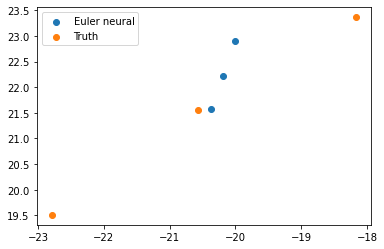

Current t limit 3
Iteration 65
selected torch.Size([2, 3])
Loss: tensor(2.3371, grad_fn=<MseLossBackward>)


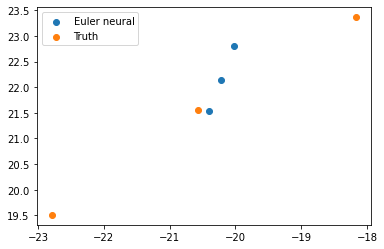

Current t limit 3
Iteration 66
selected torch.Size([2, 3])
Loss: tensor(2.2716, grad_fn=<MseLossBackward>)


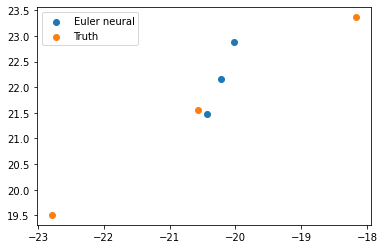

Current t limit 3
Iteration 67
selected torch.Size([2, 3])
Loss: tensor(2.2021, grad_fn=<MseLossBackward>)


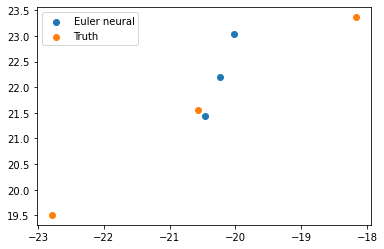

Current t limit 3
Iteration 68
selected torch.Size([2, 3])
Loss: tensor(2.1421, grad_fn=<MseLossBackward>)


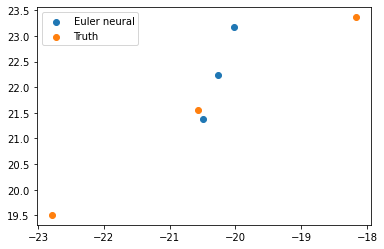

Current t limit 3
Iteration 69
selected torch.Size([2, 3])
Loss: tensor(2.0851, grad_fn=<MseLossBackward>)


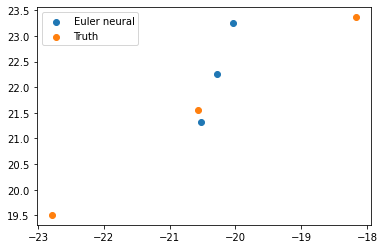

Current t limit 3
Iteration 70
selected torch.Size([2, 3])
Loss: tensor(2.0234, grad_fn=<MseLossBackward>)


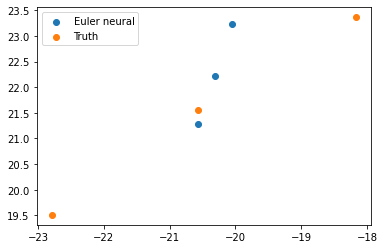

Current t limit 3
Iteration 71
selected torch.Size([2, 3])
Loss: tensor(1.9601, grad_fn=<MseLossBackward>)


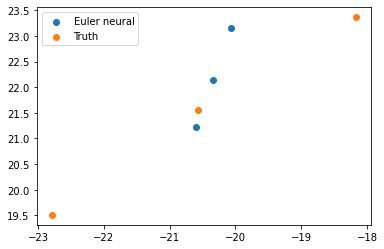

Current t limit 3
Iteration 72
selected torch.Size([2, 3])
Loss: tensor(1.9022, grad_fn=<MseLossBackward>)


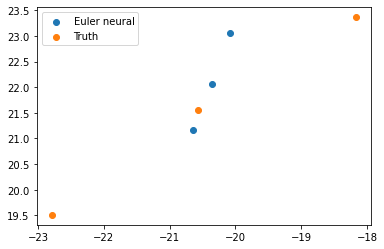

Current t limit 3
Iteration 73
selected torch.Size([2, 3])
Loss: tensor(1.8506, grad_fn=<MseLossBackward>)


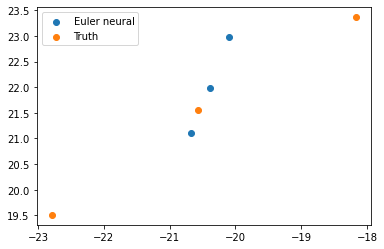

Current t limit 3
Iteration 74
selected torch.Size([2, 3])
Loss: tensor(1.8000, grad_fn=<MseLossBackward>)


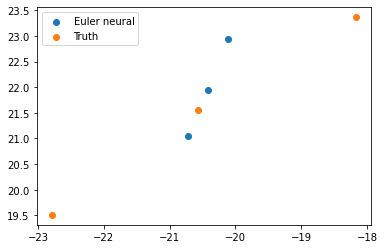

Current t limit 3
Iteration 75
selected torch.Size([2, 3])
Loss: tensor(1.7483, grad_fn=<MseLossBackward>)


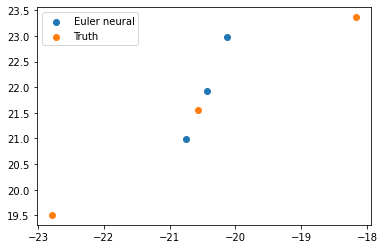

Current t limit 3
Iteration 76
selected torch.Size([2, 3])
Loss: tensor(1.6993, grad_fn=<MseLossBackward>)


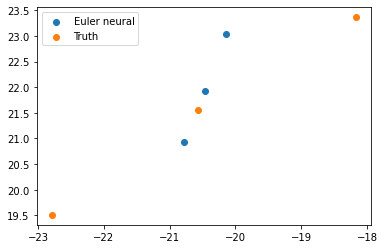

Current t limit 3
Iteration 77
selected torch.Size([2, 3])
Loss: tensor(1.6556, grad_fn=<MseLossBackward>)


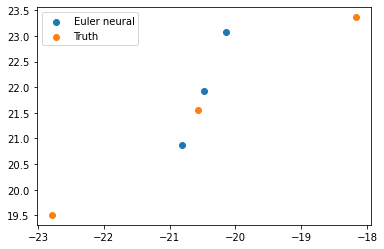

Current t limit 3
Iteration 78
selected torch.Size([2, 3])
Loss: tensor(1.6158, grad_fn=<MseLossBackward>)


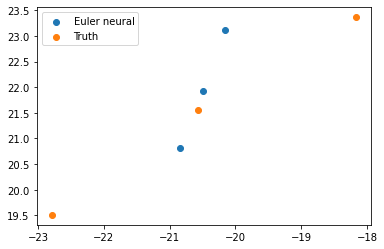

Current t limit 3
Iteration 79
selected torch.Size([2, 3])
Loss: tensor(1.5778, grad_fn=<MseLossBackward>)


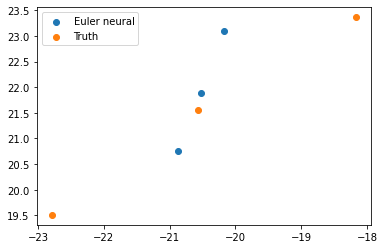

Current t limit 3
Iteration 80
selected torch.Size([2, 3])
Loss: tensor(1.5409, grad_fn=<MseLossBackward>)


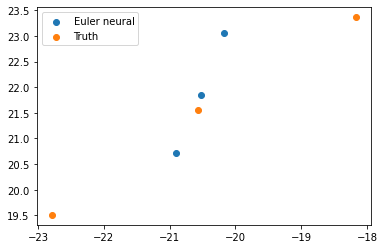

Current t limit 3
Iteration 81
selected torch.Size([2, 3])
Loss: tensor(1.5061, grad_fn=<MseLossBackward>)


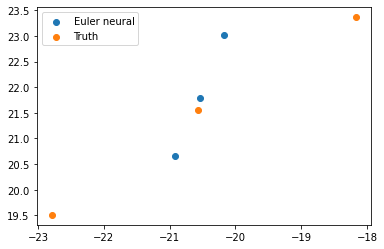

Current t limit 3
Iteration 82
selected torch.Size([2, 3])
Loss: tensor(1.4742, grad_fn=<MseLossBackward>)


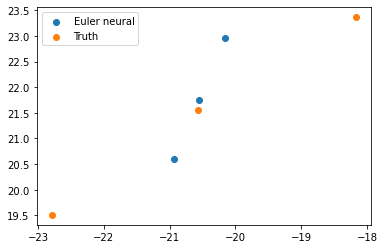

Current t limit 3
Iteration 83
selected torch.Size([2, 3])
Loss: tensor(1.4448, grad_fn=<MseLossBackward>)


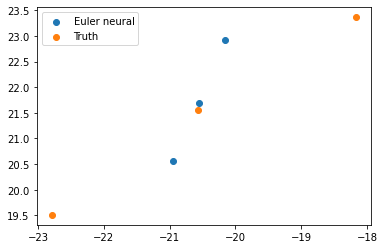

Current t limit 3
Iteration 84
selected torch.Size([2, 3])
Loss: tensor(1.4169, grad_fn=<MseLossBackward>)


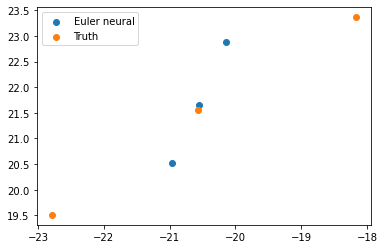

Current t limit 3
Iteration 85
selected torch.Size([2, 3])
Loss: tensor(1.3898, grad_fn=<MseLossBackward>)


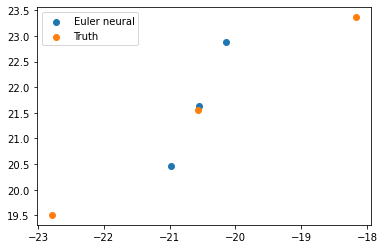

Current t limit 3
Iteration 86
selected torch.Size([2, 3])
Loss: tensor(1.3633, grad_fn=<MseLossBackward>)


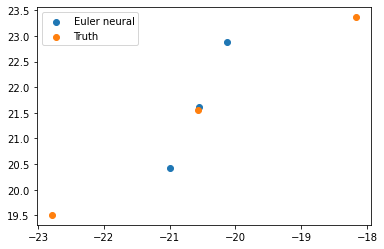

Current t limit 3
Iteration 87
selected torch.Size([2, 3])
Loss: tensor(1.3380, grad_fn=<MseLossBackward>)


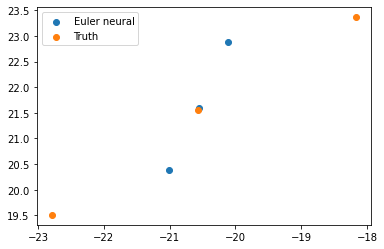

Current t limit 3
Iteration 88
selected torch.Size([2, 3])
Loss: tensor(1.3139, grad_fn=<MseLossBackward>)


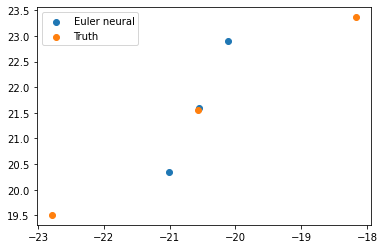

Current t limit 3
Iteration 89
selected torch.Size([2, 3])
Loss: tensor(1.2908, grad_fn=<MseLossBackward>)


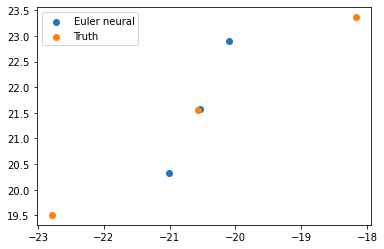

Current t limit 3
Iteration 90
selected torch.Size([2, 3])
Loss: tensor(1.2681, grad_fn=<MseLossBackward>)


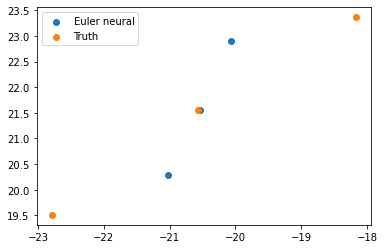

Current t limit 3
Iteration 91
selected torch.Size([2, 3])
Loss: tensor(1.2456, grad_fn=<MseLossBackward>)


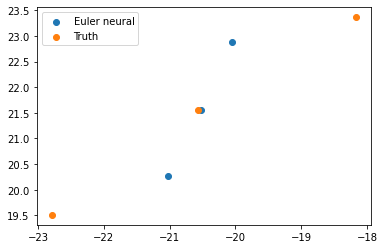

Current t limit 3
Iteration 92
selected torch.Size([2, 3])
Loss: tensor(1.2235, grad_fn=<MseLossBackward>)


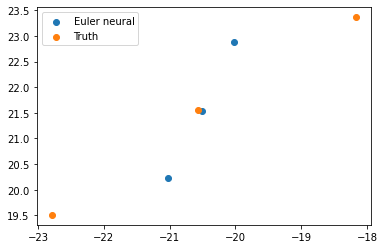

Current t limit 3
Iteration 93
selected torch.Size([2, 3])
Loss: tensor(1.2018, grad_fn=<MseLossBackward>)


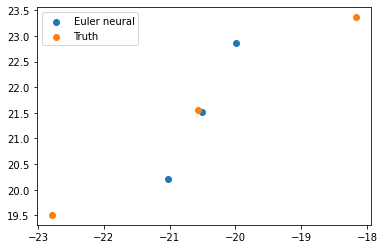

Current t limit 3
Iteration 94
selected torch.Size([2, 3])
Loss: tensor(1.1808, grad_fn=<MseLossBackward>)


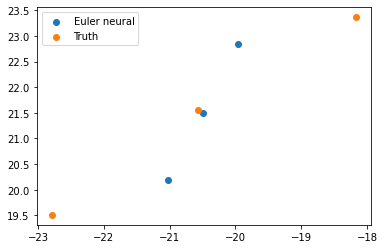

Current t limit 3
Iteration 95
selected torch.Size([2, 3])
Loss: tensor(1.1605, grad_fn=<MseLossBackward>)


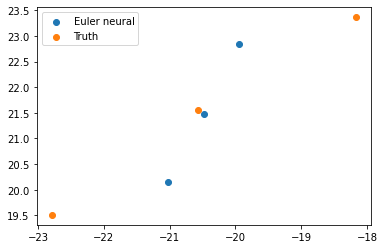

Current t limit 3
Iteration 96
selected torch.Size([2, 3])
Loss: tensor(1.1406, grad_fn=<MseLossBackward>)


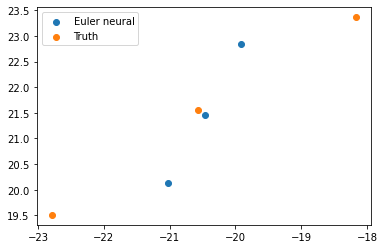

Current t limit 3
Iteration 97
selected torch.Size([2, 3])
Loss: tensor(1.1211, grad_fn=<MseLossBackward>)


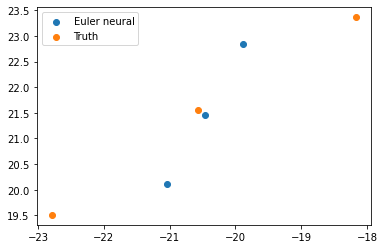

Current t limit 3
Iteration 98
selected torch.Size([2, 3])
Loss: tensor(1.1020, grad_fn=<MseLossBackward>)


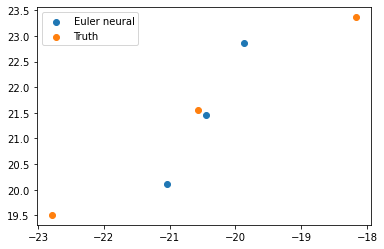

Current t limit 3
Iteration 99
selected torch.Size([2, 3])
Loss: tensor(1.0833, grad_fn=<MseLossBackward>)


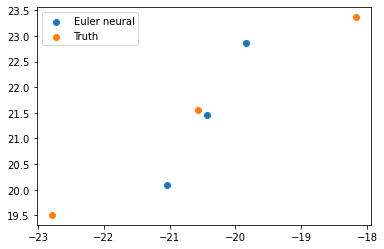

Current t limit 3
Iteration 100
selected torch.Size([2, 3])
Loss: tensor(1.0649, grad_fn=<MseLossBackward>)


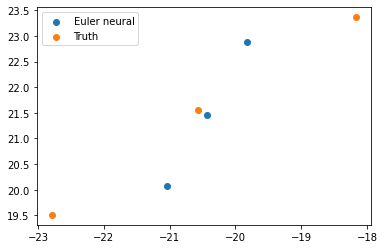

Current t limit 3
Iteration 101
selected torch.Size([2, 3])
Loss: tensor(1.0470, grad_fn=<MseLossBackward>)


KeyboardInterrupt: 

In [60]:
for i in range(1000):
    print('Iteration', i)
    optimizer.zero_grad()

    z_pred =  nOde.solve(y_train[:,0], 15., 5., 100) #odeint_adjoint(nOde,  nOde.up(torch.tensor(0.), torch.randn(2)), torch.linspace(15,5,100)).T
    y_pred = nOde.down(z_pred)
    selection_indicator = (torch.rand(t_limit) > .2) #(torch.rand(y_train.shape[1]) > .2)
    y_pred_selected = y_pred[:,:t_limit]#[:,selection_indicator] #(y_train.T[selection_indicator]).T
    y_train_selected = y_train[:,:t_limit]#[:,selection_indicator]
    print('selected', y_train_selected.shape)
    loss = criterion(y_pred_selected, y_train_selected)

    print('Loss:', loss)

    plt.scatter(y_pred[0].detach()[:t_limit], y_pred[1].detach()[:t_limit], label='Euler neural')
    plt.scatter(y_train[0][:t_limit], y_train[1][:t_limit], label='Truth')
    plt.legend()
    plt.show()

    if loss.item() < 0.07:
        t_limit += 1

    print('Current t limit', t_limit)

    loss.backward()
    optimizer.step()

In [290]:
z_pred =  nOde.solve(y_train[:,0], 15., 0., 200)

In [291]:
y_pred = nOde.down(z_pred)
y_pred.shape

torch.Size([2, 200])

In [292]:
x_full = torch.linspace(15.,0.,200)

In [293]:
y_full = spiral_easier(x_full)

In [294]:
y_full.shape

torch.Size([2, 200])

In [295]:
#plt.scatter(y_train[0][:t_limit], y_train[1][:t_limit], label='Truth')

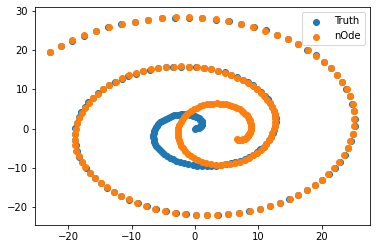

In [296]:
plt.scatter(y_full[0], y_full[1], label='Truth')
plt.scatter(y_pred[0].detach(), y_pred[1].detach(), label='nOde')
plt.legend()

In [282]:
torch.save(nOde, 'model1.pt')

# Sine wave

Let's see if we can learn the sine wave function

In [70]:
x_train = torch.linspace(-10,10,100).reshape(-1,1)
y_train = torch.sin(x_train)

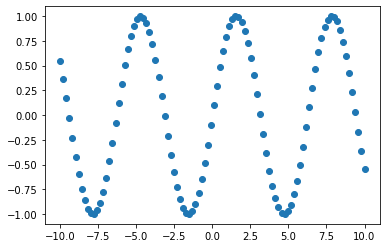

In [71]:
plt.scatter(x_train,y_train)

In [72]:
x_test = torch.linspace(10,20,50).reshape(-1,1)
y_test = torch.sin(x_test)

In [158]:
class NeuralODESin(nn.Module):
    def __init__(self, phase_space_dim, projection_dim, hidden_layer_dim):
        super().__init__()
        self.delta_net = nn.Sequential(
            nn.Linear(projection_dim + 1, hidden_layer_dim),
            nn.ReLU(),
            nn.Linear(hidden_layer_dim, hidden_layer_dim),
            nn.ReLU(),
            nn.Linear(hidden_layer_dim, hidden_layer_dim),
            nn.ReLU(),
            nn.Linear(hidden_layer_dim, projection_dim),
        )
        self.upprojector_net = nn.Linear(phase_space_dim + 1, projection_dim)
        self.downprojector_net = nn.Linear(projection_dim, phase_space_dim)

    def up(self, t, y):
        concat = torch.hstack((t.reshape(1,1), y.reshape(1,-1)))
        z = self.upprojector_net(concat)
        return z.reshape(-1)

    def down(self, z):
        return self.downprojector_net(z)

    def forward(self, t, yt):
        concat = torch.hstack((t.reshape(1,1), yt.reshape(1,-1)))
        return self.delta_net(concat).reshape(-1)

    def solve(self, x_train, y_train):
        y_start = y_train[0]
        t_start = x_train[0]
        z_start = self.up(torch.tensor(t_start), y_start)
        z_pred = odeint(self, z_start, x_train.reshape(-1))
        return z_pred

In [159]:
nde = NeuralODESin(1,50,100)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(nde.parameters())

In [160]:
t_limit = 3

/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


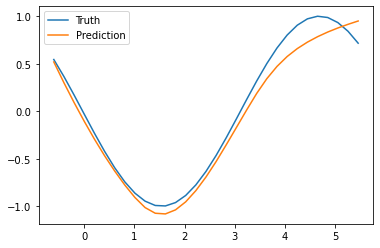

Loss 0.015410922467708588
Current t limit 31


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


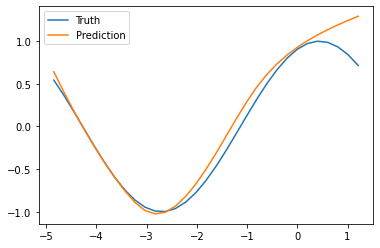

Loss 0.025261010974645615
Current t limit 31


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


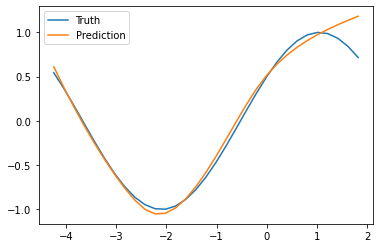

Loss 0.012444667518138885
Current t limit 31


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


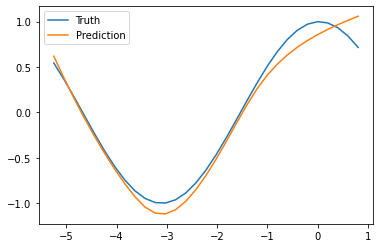

Loss 0.012661917135119438
Current t limit 31


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


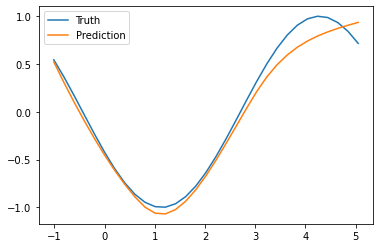

Loss 0.012399846687912941
Current t limit 31


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


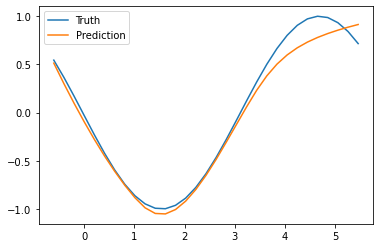

Loss 0.011672554537653923
Current t limit 31


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


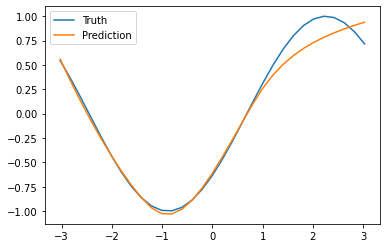

Loss 0.01066476758569479
Current t limit 31


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


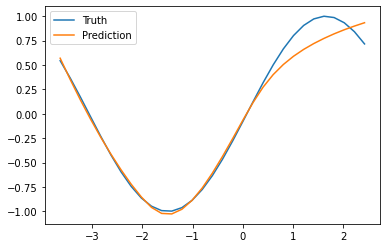

Loss 0.011279325932264328
Current t limit 31


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


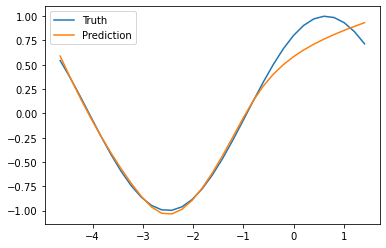

Loss 0.011961888521909714
Current t limit 31


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


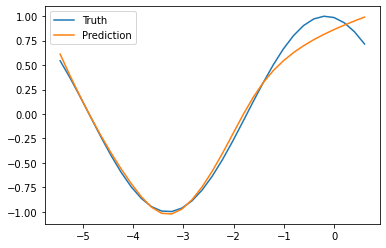

Loss 0.009767943061888218
Current t limit 32


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


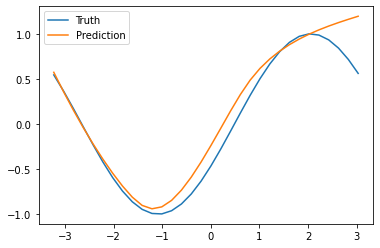

Loss 0.03395330160856247
Current t limit 32


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


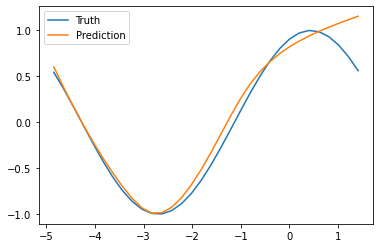

Loss 0.02282060869038105
Current t limit 32


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


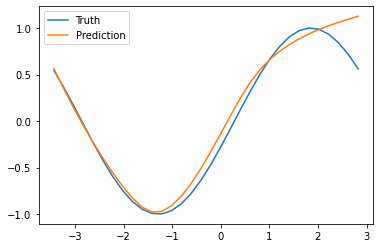

Loss 0.02101200819015503
Current t limit 32


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


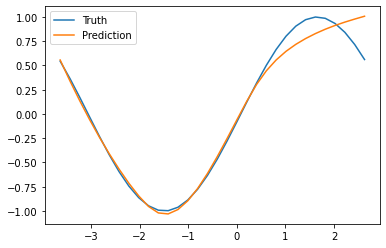

Loss 0.013854178600013256
Current t limit 32


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


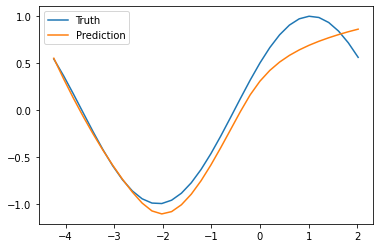

Loss 0.027012035250663757
Current t limit 32


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


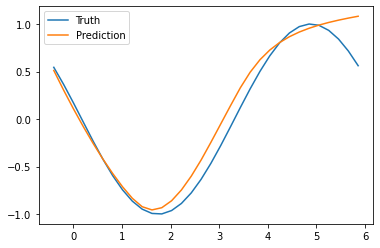

Loss 0.02523297630250454
Current t limit 32


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


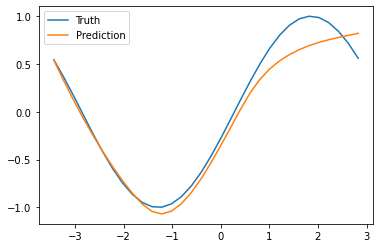

Loss 0.021604737266898155
Current t limit 32


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


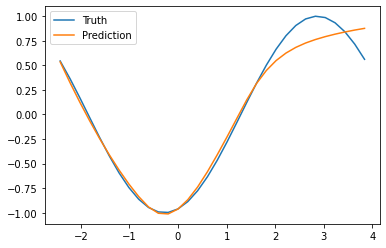

Loss 0.012649418786168098
Current t limit 32


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


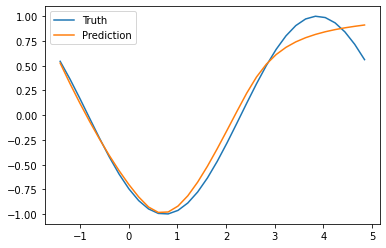

Loss 0.012470075860619545
Current t limit 32


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


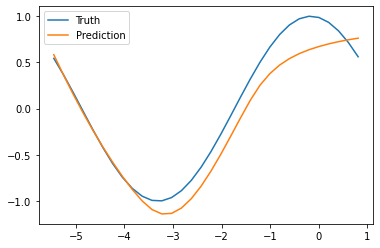

Loss 0.04034793749451637
Current t limit 32


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


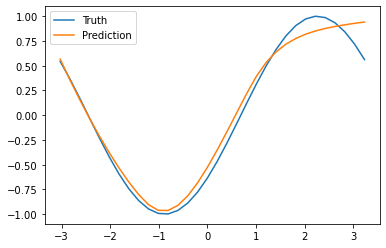

Loss 0.011882945895195007
Current t limit 32


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


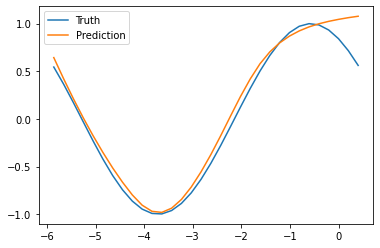

Loss 0.017400257289409637
Current t limit 32


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


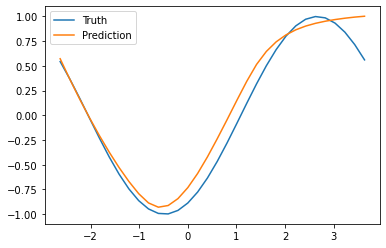

Loss 0.023003388196229935
Current t limit 32


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


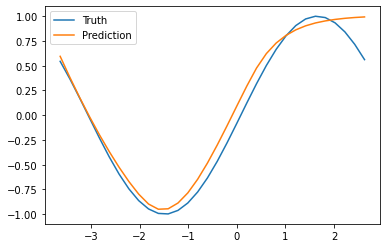

Loss 0.016727931797504425
Current t limit 32


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


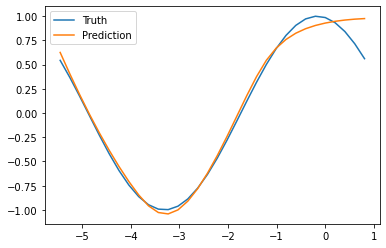

Loss 0.009778411127626896
Current t limit 33


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


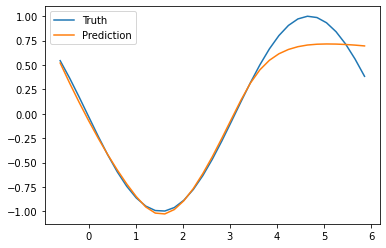

Loss 0.01665879413485527
Current t limit 33


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


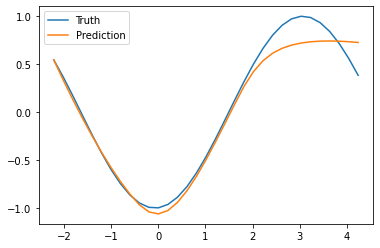

Loss 0.01684349961578846
Current t limit 33


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


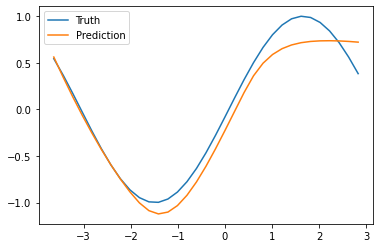

Loss 0.024054566398262978
Current t limit 33


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


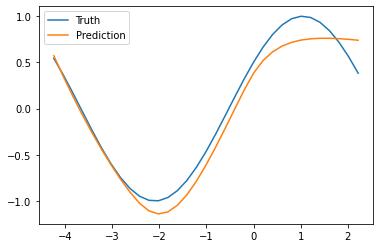

Loss 0.02244189940392971
Current t limit 33


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


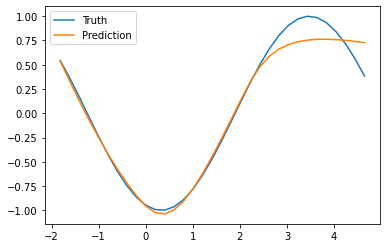

Loss 0.013049705885350704
Current t limit 33


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


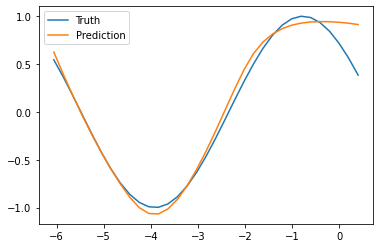

Loss 0.017363274469971657
Current t limit 33


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


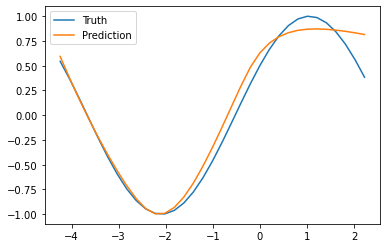

Loss 0.015431010164320469
Current t limit 33


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


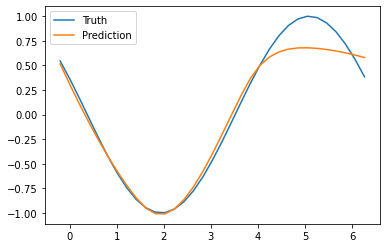

Loss 0.017507284879684448
Current t limit 33


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


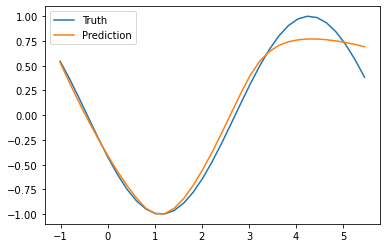

Loss 0.012460279278457165
Current t limit 33


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


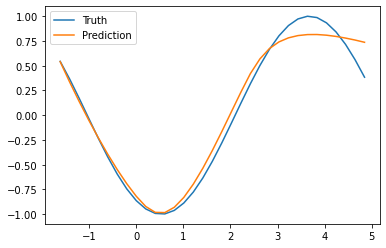

Loss 0.011896731331944466
Current t limit 33


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


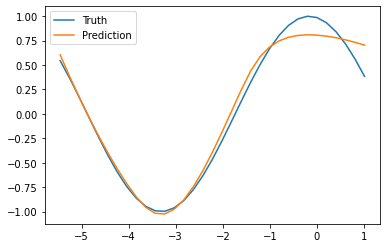

Loss 0.010327287949621677
Current t limit 33


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


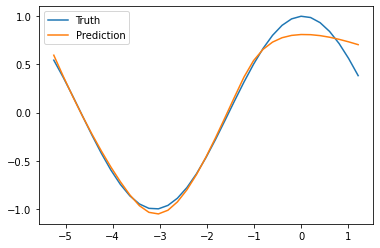

Loss 0.008983379229903221
Current t limit 34


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


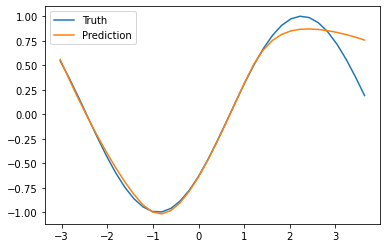

Loss 0.018633749336004257
Current t limit 34


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


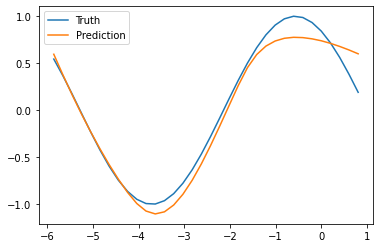

Loss 0.017393073067069054
Current t limit 34


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


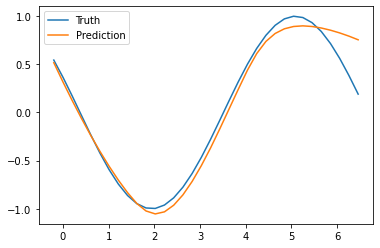

Loss 0.02061794325709343
Current t limit 34


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


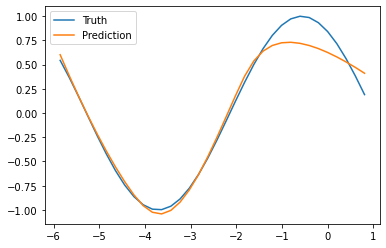

Loss 0.014204160310328007
Current t limit 34


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


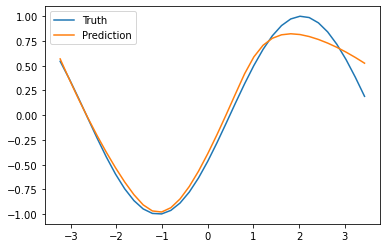

Loss 0.0111417006701231
Current t limit 34


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


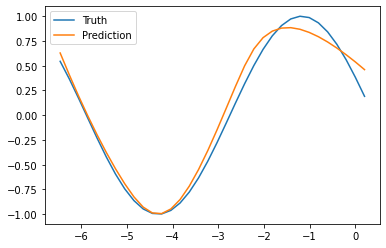

Loss 0.010785041376948357
Current t limit 34


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


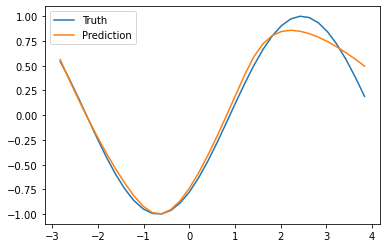

Loss 0.008291422389447689
Current t limit 35


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


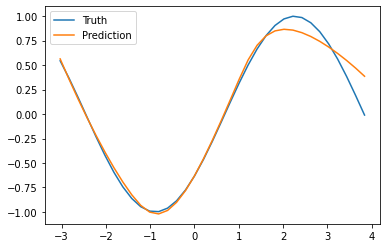

Loss 0.010578246787190437
Current t limit 35


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


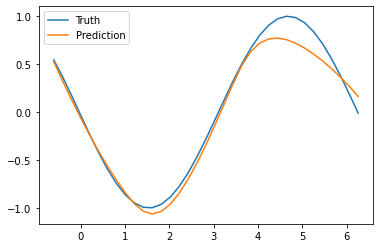

Loss 0.012944619171321392
Current t limit 35


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


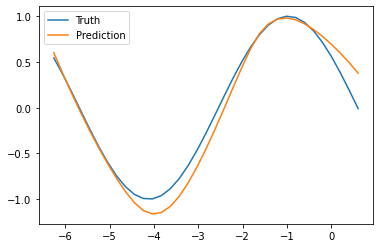

Loss 0.018204137682914734
Current t limit 35


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


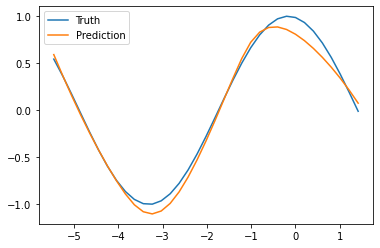

Loss 0.007125752046704292
Current t limit 36


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


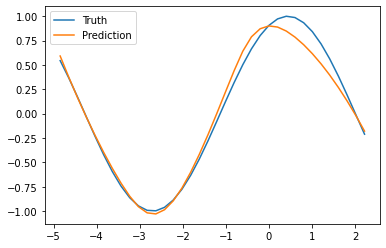

Loss 0.00958880316466093
Current t limit 37


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


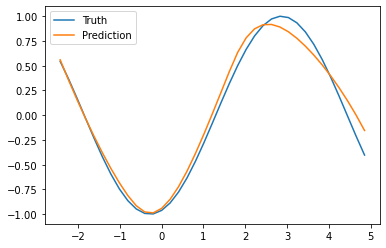

Loss 0.009214100427925587
Current t limit 38


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


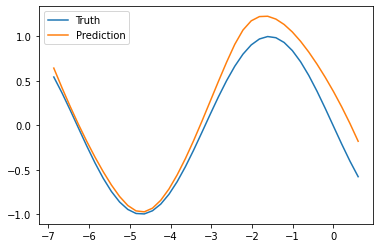

Loss 0.04314376413822174
Current t limit 38


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


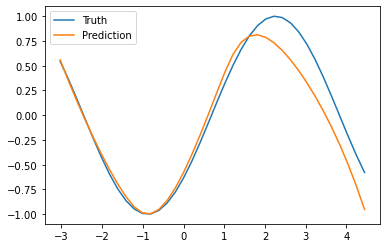

Loss 0.03928424045443535
Current t limit 38


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


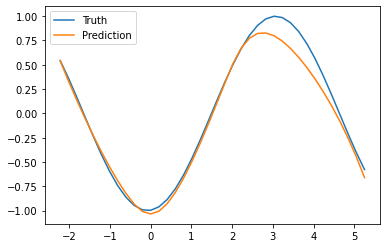

Loss 0.01177124585956335
Current t limit 38


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


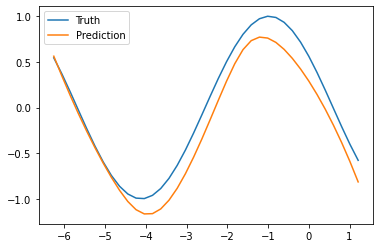

Loss 0.03963010758161545
Current t limit 38


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


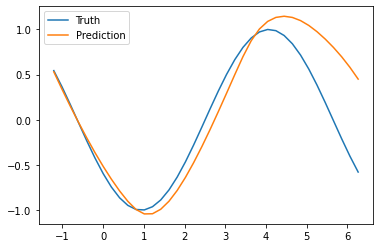

Loss 0.13869750499725342
Current t limit 38


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


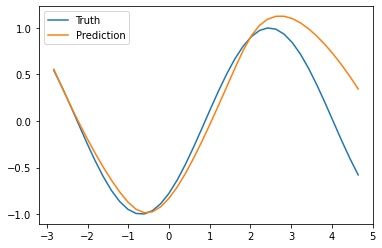

Loss 0.1078660637140274
Current t limit 38


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


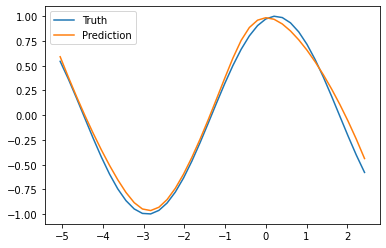

Loss 0.00498183211311698
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


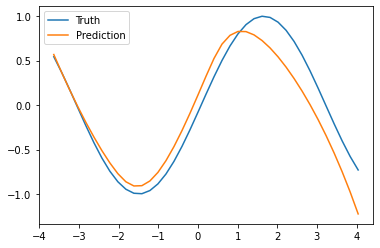

Loss 0.05827001482248306
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


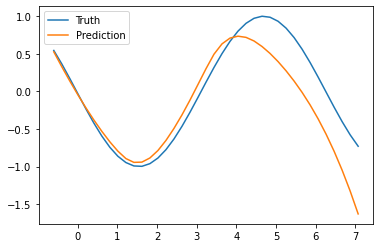

Loss 0.13099905848503113
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


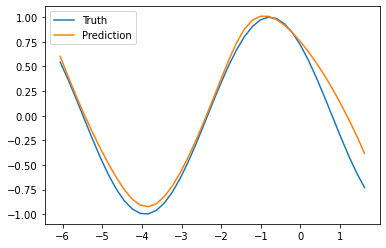

Loss 0.020384682342410088
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


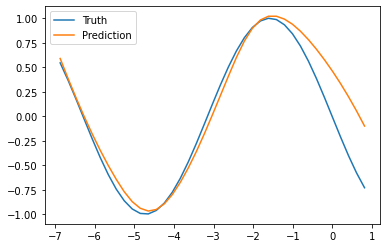

Loss 0.053994204849004745
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


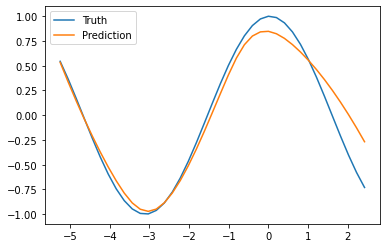

Loss 0.026008987799286842
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


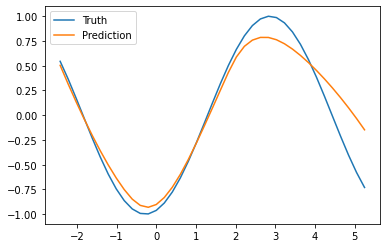

Loss 0.03787235543131828
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


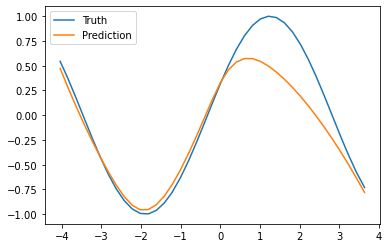

Loss 0.06341713666915894
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


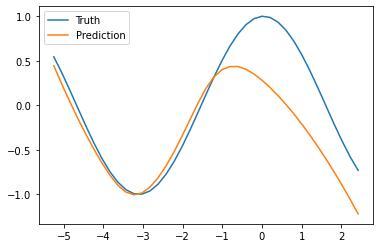

Loss 0.1812896430492401
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


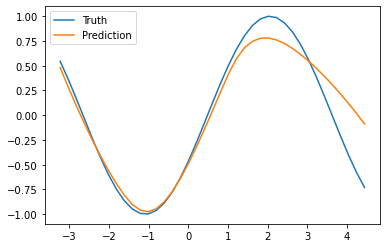

Loss 0.043434493243694305
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


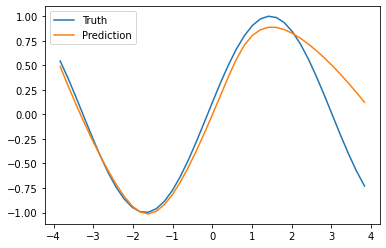

Loss 0.07530441135168076
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


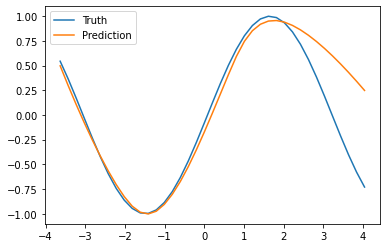

Loss 0.1008090153336525
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


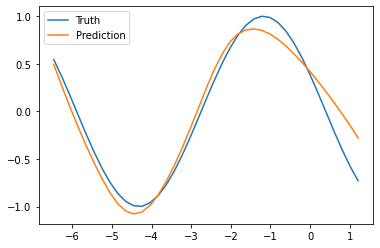

Loss 0.026044463738799095
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


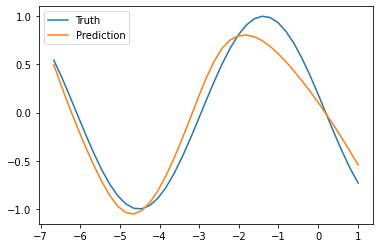

Loss 0.028200559318065643
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


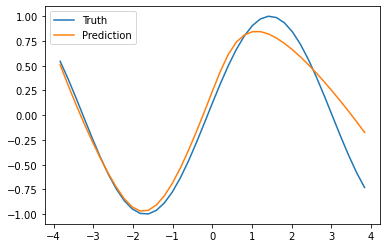

Loss 0.033224862068891525
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


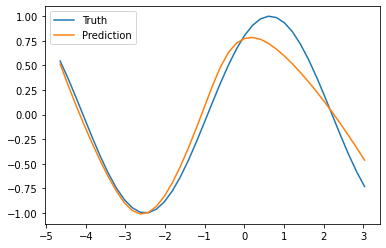

Loss 0.02526649832725525
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


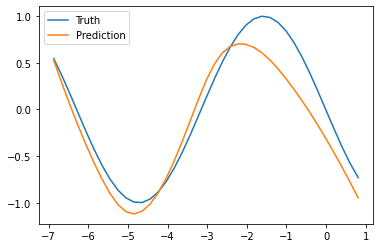

Loss 0.062421683222055435
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


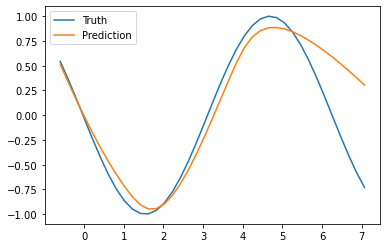

Loss 0.10966594517230988
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


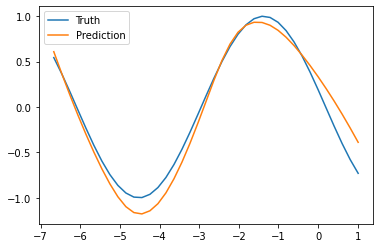

Loss 0.021071791648864746
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


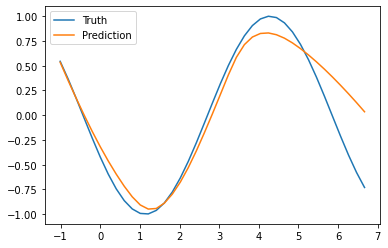

Loss 0.05872558802366257
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


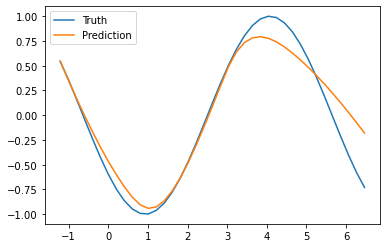

Loss 0.03406069800257683
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


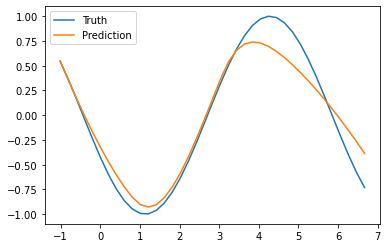

Loss 0.02845928631722927
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


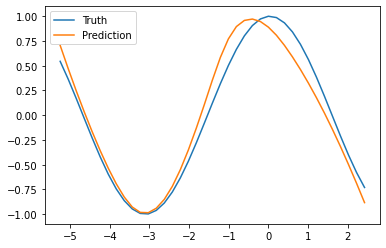

Loss 0.021811889484524727
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


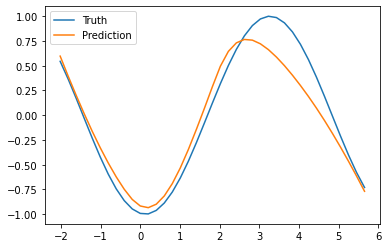

Loss 0.038417067378759384
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


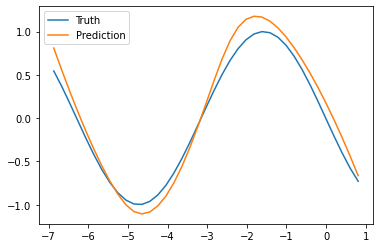

Loss 0.01935681514441967
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


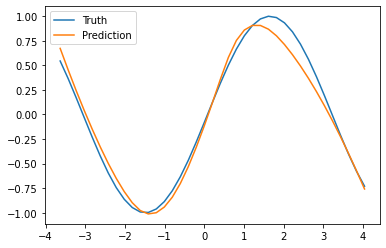

Loss 0.010276987217366695
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


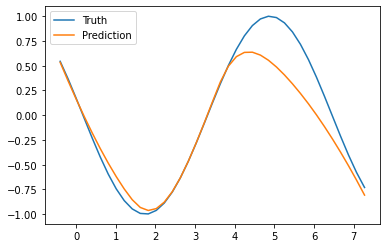

Loss 0.05358514562249184
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


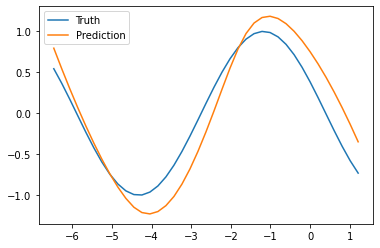

Loss 0.07850221544504166
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


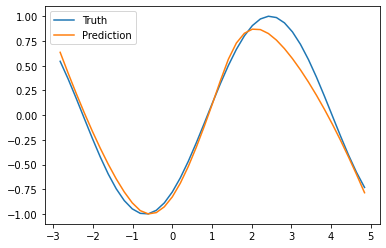

Loss 0.012882383540272713
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


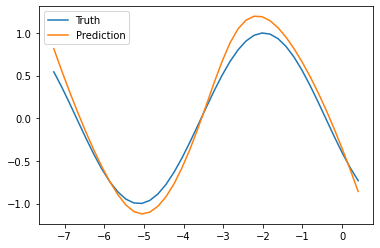

Loss 0.01795514114201069
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


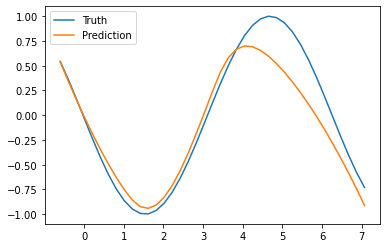

Loss 0.05382676050066948
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


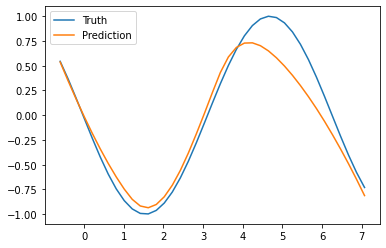

Loss 0.03767199441790581
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


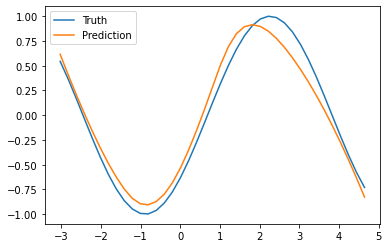

Loss 0.01802774891257286
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


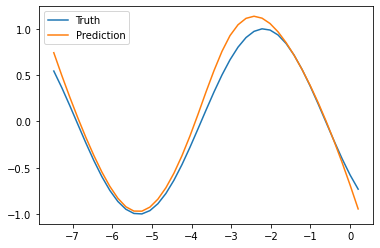

Loss 0.014798879623413086
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


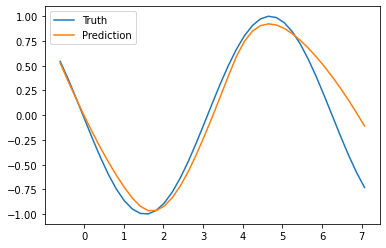

Loss 0.04637448489665985
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


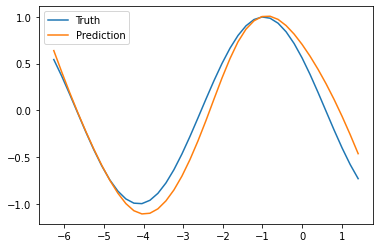

Loss 0.028040098026394844
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


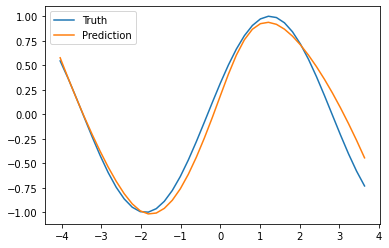

Loss 0.016300177201628685
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


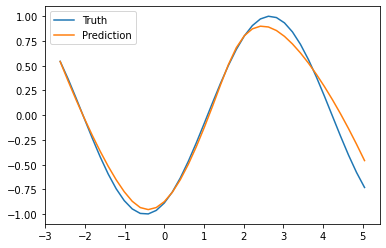

Loss 0.011249450966715813
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


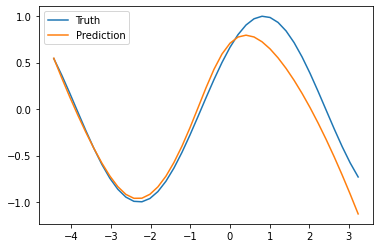

Loss 0.04478299245238304
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


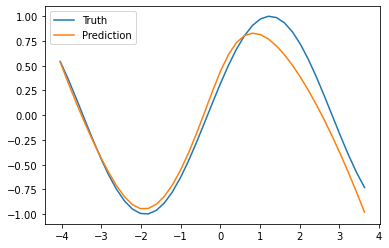

Loss 0.026759186759591103
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


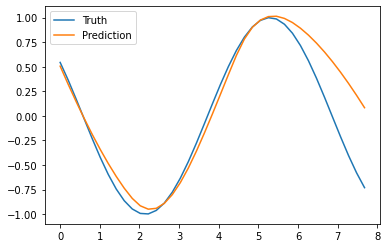

Loss 0.08081626892089844
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


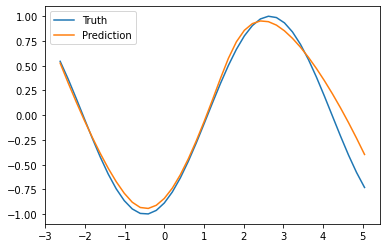

Loss 0.014882368966937065
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


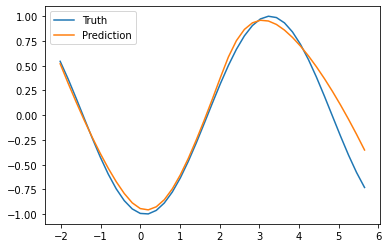

Loss 0.018051177263259888
Current t limit 39


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


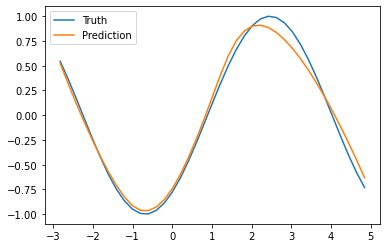

Loss 0.006168890278786421
Current t limit 40


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


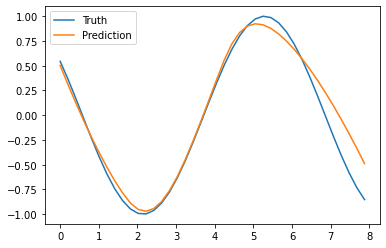

Loss 0.02118576504290104
Current t limit 40


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


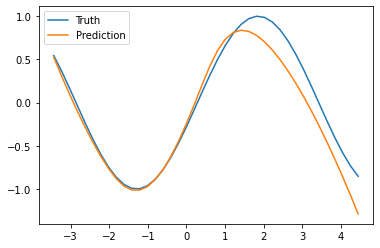

Loss 0.03546525165438652
Current t limit 40


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


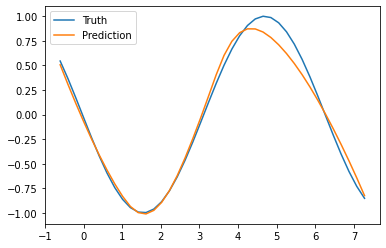

Loss 0.00833064503967762
Current t limit 41


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


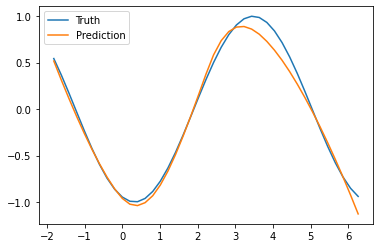

Loss 0.007425169926136732
Current t limit 42


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


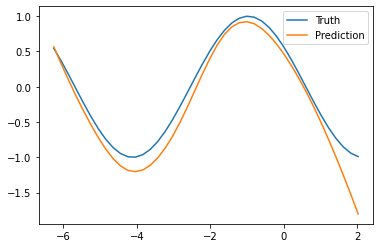

Loss 0.047472789883613586
Current t limit 42


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


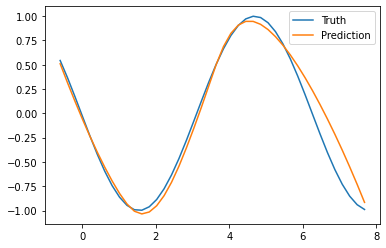

Loss 0.01860031671822071
Current t limit 42


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


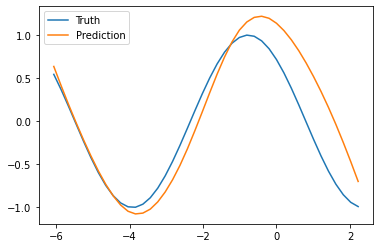

Loss 0.12102828919887543
Current t limit 42


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


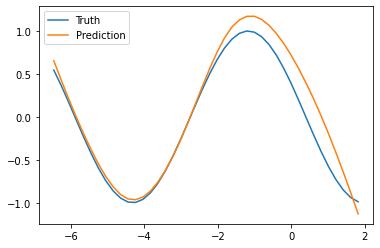

Loss 0.03506628796458244
Current t limit 42


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


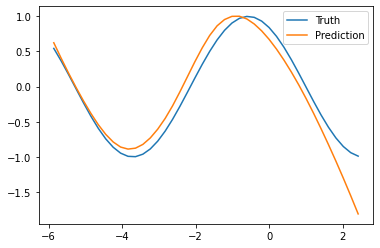

Loss 0.05299939587712288
Current t limit 42


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


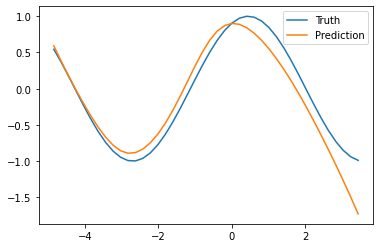

Loss 0.05409938842058182
Current t limit 42


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


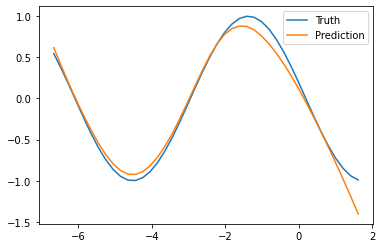

Loss 0.011863671243190765
Current t limit 42


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


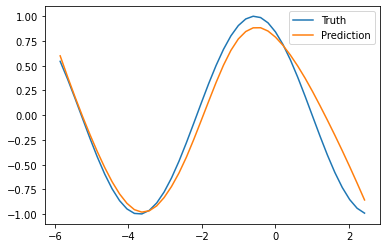

Loss 0.026428965851664543
Current t limit 42


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


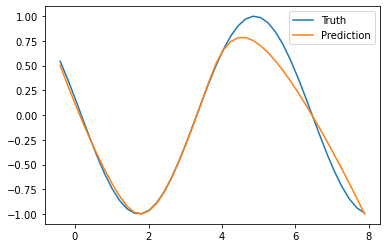

Loss 0.015388639643788338
Current t limit 42


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


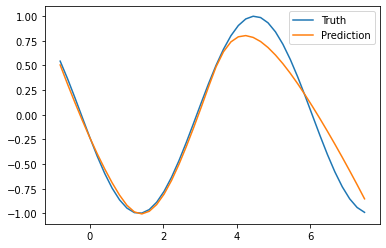

Loss 0.018462641164660454
Current t limit 42


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


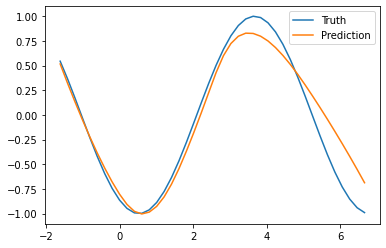

Loss 0.03132260590791702
Current t limit 42


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


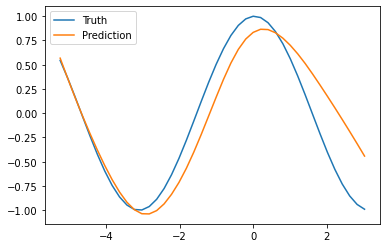

Loss 0.09390103816986084
Current t limit 42


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


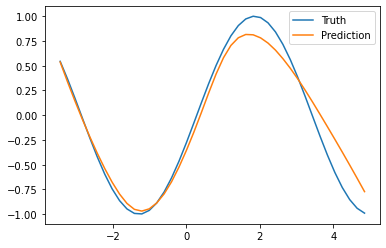

Loss 0.02289053425192833
Current t limit 42


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


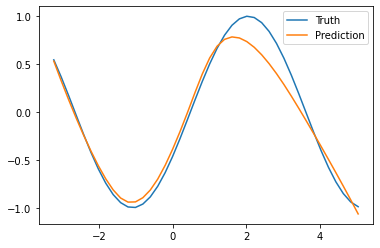

Loss 0.01913626492023468
Current t limit 42


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


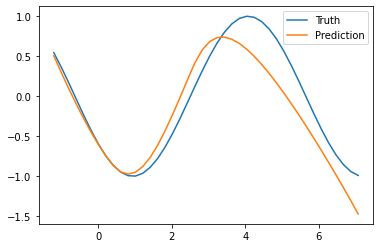

Loss 0.08329572528600693
Current t limit 42


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


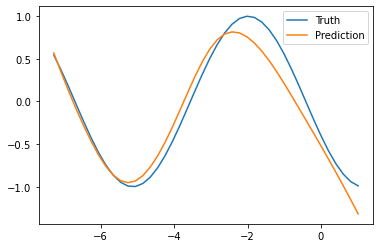

Loss 0.032559145241975784
Current t limit 42


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


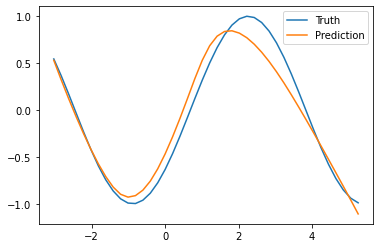

Loss 0.023620089516043663
Current t limit 42


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


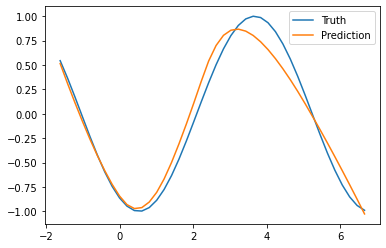

Loss 0.0186734888702631
Current t limit 42


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


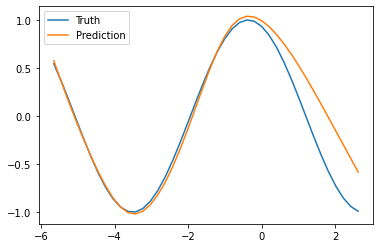

Loss 0.05509774014353752
Current t limit 42


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


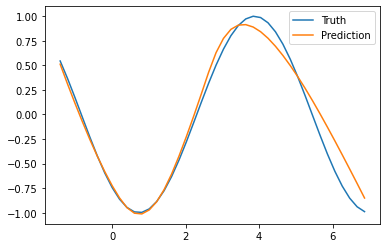

Loss 0.016274694353342056
Current t limit 42


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


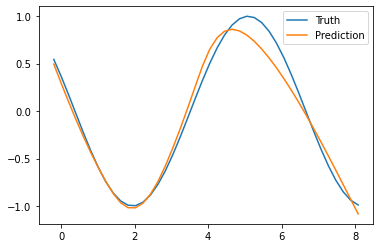

Loss 0.014134889468550682
Current t limit 42


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


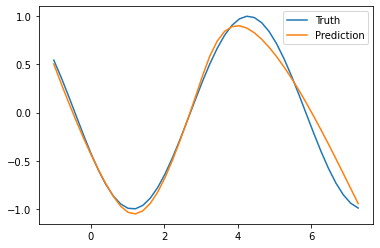

Loss 0.011179258115589619
Current t limit 42


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


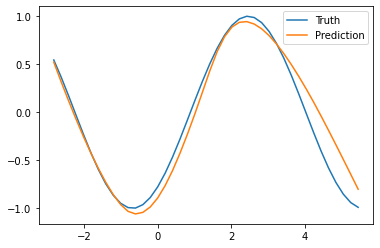

Loss 0.025789856910705566
Current t limit 42


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


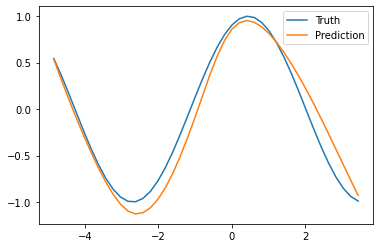

Loss 0.02435954101383686
Current t limit 42


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


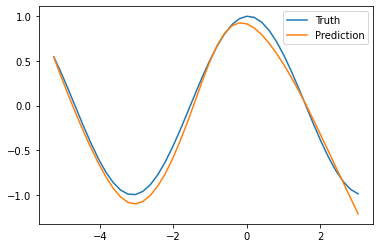

Loss 0.007943404838442802
Current t limit 43


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


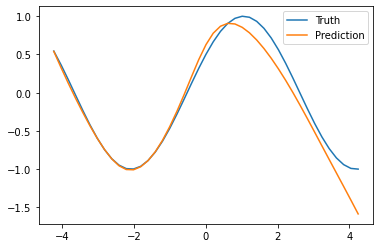

Loss 0.027964822947978973
Current t limit 43


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


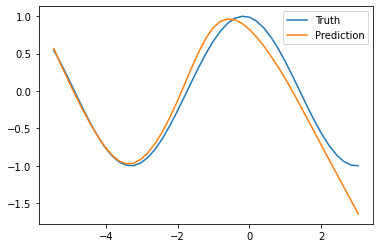

Loss 0.036450617015361786
Current t limit 43


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


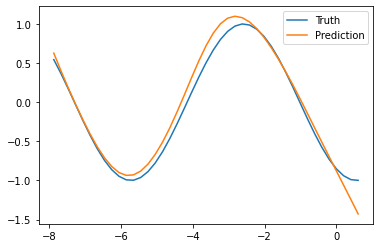

Loss 0.01589163765311241
Current t limit 43


/var/folders/wp/1d_kn7_9637fpphqd2n6z1nr0000gn/T/ipykernel_4465/3578028898.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_start = self.up(torch.tensor(t_start), y_start)


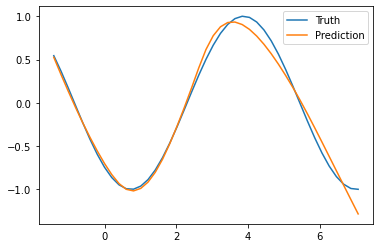

Loss 0.007643873803317547
Current t limit 44


KeyboardInterrupt: 

In [162]:
for i in range(10000):
    optimizer.zero_grad()
    
    t_start = torch.randint(high=max(1,t_limit-1),size=(1,))
    x_train_batch = x_train[:t_limit] - x_train[t_start]
    y_train_batch = y_train[:t_limit]
        
    z_pred = nde.solve(x_train_batch, y_train_batch)
    y_pred = nde.down(z_pred)

    loss = criterion(y_pred, y_train_batch)
    plt.plot(x_train_batch, y_train_batch, label='Truth')
    plt.plot(x_train_batch, y_pred.detach(), label='Prediction')
    plt.legend()
    plt.show()

    if loss.item() < 0.01:
        t_limit += 1

    print('Loss', loss.item())
    print('Current t limit', t_limit)

    loss.backward()
    optimizer.step()